In [1]:
# 구글 드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 딥러닝 모형 학습을 위한 기능 import
# -*- coding: utf-8 -*-
%tensorflow_version 1.x
import tensorflow as tf

import pandas as pd
import numpy as np

import datetime
import os
import glob

import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.models import Model

from keras import layers
from keras.layers import *
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.optimizers import Adam

from pickle import dump, load
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

from statsmodels.distributions.empirical_distribution import ECDF
!pip install h5py==2.10.0

%matplotlib inline
print(tf.__version__)


TensorFlow 1.x selected.


Using TensorFlow backend.
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 2.9 MB 5.3 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


1.15.2


In [3]:
# 14년1월 ~ 21년 6월까지 데이터를 활용
# openAPI를 통해 6개월 단위로 수집가능함에 따라, 병합처리 필요

path = '/content/drive/MyDrive/data/flood/'

raw_period = {'startdt': ['20140101', '20140701', '20150101', '20150701', '20160101', '20160701', '20170101', '20170701', '20180101', '20180701', '20190101', '20190701', '20200101', '20200701', '20210101'],
                'enddt': ['20140630', '20141231', '20150630', '20151231', '20160630', '20161231', '20170630', '20171231', '20180630', '20181231', '20190630', '20191231', '20200630', '20201231', '20210630']}

df_period = pd.DataFrame(raw_period)
df_period

,startdt,enddt
0,20140101,20140630
1,20140701,20141231
2,20150101,20150630
3,20150701,20151231
4,20160101,20160630
5,20160701,20161231
6,20170101,20170630
7,20170701,20171231
8,20180101,20180630
9,20180701,20181231


In [4]:
# 진관교 및 상류지역 수위 및 강우량 지점 코드 
# 해당 코드명이 파일 이름으로 포함되어 있음

raw_obscd = {'obscd': ['1018620', '1018625', '1018630', '10184110', '10184220'],
            'desc': ['수위_남양주시 부평교', '수위_남양주시 내곡교', '수위_남양주시 진관교', '강우_진관교', '강우_진접읍사무소']}

df_obscd = pd.DataFrame(raw_obscd)
df_obscd


,obscd,desc
0,1018620,수위_남양주시 부평교
1,1018625,수위_남양주시 내곡교
2,1018630,수위_남양주시 진관교
3,10184110,강우_진관교
4,10184220,강우_진접읍사무소


In [5]:
# 기준이 되는 Date를 생성함

start = datetime.datetime.strptime("2015050101", "%Y%m%d%H")
end = datetime.datetime.strptime("2020110123", "%Y%m%d%H")
date_generated = [start + datetime.timedelta(hours=x) for x in range(0, (end-start).days * 24 + 23)]

df = pd.DataFrame(date_generated, columns =['Date'])
df['ymdh'] = df['Date'].apply(lambda x: int(x.strftime('%Y%m%d%H'))) 
df

,Date,ymdh
0,2015-05-01 01:00:00,2015050101
1,2015-05-01 02:00:00,2015050102
2,2015-05-01 03:00:00,2015050103
3,2015-05-01 04:00:00,2015050104
4,2015-05-01 05:00:00,2015050105
...,...,...
48282,2020-11-01 19:00:00,2020110119
48283,2020-11-01 20:00:00,2020110120
48284,2020-11-01 21:00:00,2020110121
48285,2020-11-01 22:00:00,2020110122


In [7]:
# 앞에서 만든 데이터프레임을 이용하여, 각 파일들을 읽고 합치는 작업을 함

for i, row_i in df_obscd.iterrows():
  obscd = row_i['obscd']   
  
  files = glob.glob(path + '*' + obscd + '*.csv')
  files.sort()
  print(files)
  
  # Read files
  for index, file in enumerate(files):
    #print('Reading files ... : ' + file)
    try:
      if(index == 0):
        df_wl = pd.read_csv(file)
      else:
        temp = pd.read_csv(file)
        df_wl = df_wl.append(temp)
    except:
      print('Pass file : ' + file)
      continue
  df_wl.columns = ['ymdh', obscd]
  df = df.merge(df_wl, how='left', on = 'ymdh')
  #display(df)

['/content/drive/MyDrive/data/flood/wl_1018620_20140101_20140630.csv', '/content/drive/MyDrive/data/flood/wl_1018620_20140701_20141231.csv', '/content/drive/MyDrive/data/flood/wl_1018620_20150101_20150630.csv', '/content/drive/MyDrive/data/flood/wl_1018620_20150701_20151231.csv', '/content/drive/MyDrive/data/flood/wl_1018620_20160101_20160630.csv', '/content/drive/MyDrive/data/flood/wl_1018620_20160701_20161231.csv', '/content/drive/MyDrive/data/flood/wl_1018620_20170101_20170630.csv', '/content/drive/MyDrive/data/flood/wl_1018620_20170701_20171231.csv', '/content/drive/MyDrive/data/flood/wl_1018620_20180101_20180630.csv', '/content/drive/MyDrive/data/flood/wl_1018620_20180701_20181231.csv', '/content/drive/MyDrive/data/flood/wl_1018620_20190101_20190630.csv', '/content/drive/MyDrive/data/flood/wl_1018620_20190701_20191231.csv', '/content/drive/MyDrive/data/flood/wl_1018620_20200101_20200630.csv', '/content/drive/MyDrive/data/flood/wl_1018620_20200701_20201231.csv', '/content/drive/MyD

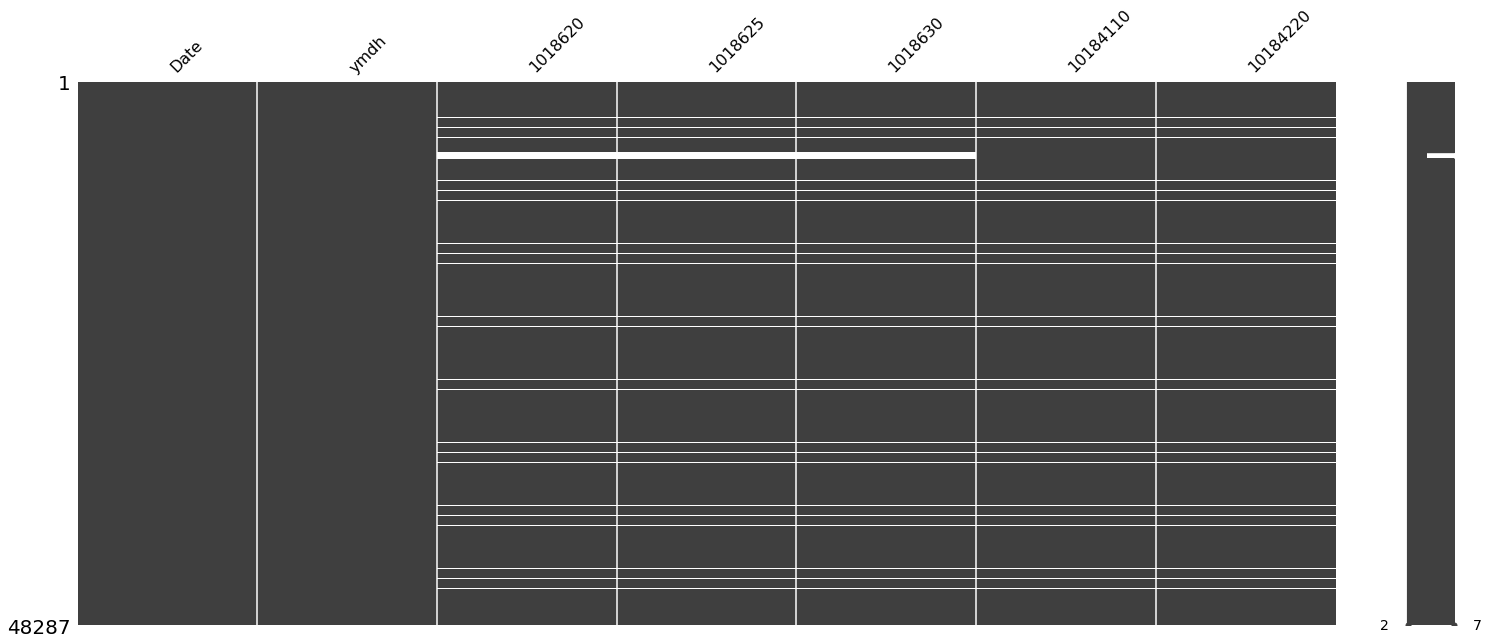

In [8]:
import missingno as msno

msno.matrix(df)

In [9]:
# 결측치는 선형보간으로 처리
# LSTM의 경우 연속된 값을 입력으로 해야함에 따라 결측치 보간을 필수적으로 해야함

df['1018620'] = df['1018620'].interpolate(limit = 1)
df['1018625'] = df['1018625'].interpolate(limit = 1)
df['1018630'] = df['1018630'].interpolate(limit = 1)
df['10184110'] = df['10184110'].fillna(0)
df['10184220'] = df['10184220'].fillna(0)
# 보간 참고

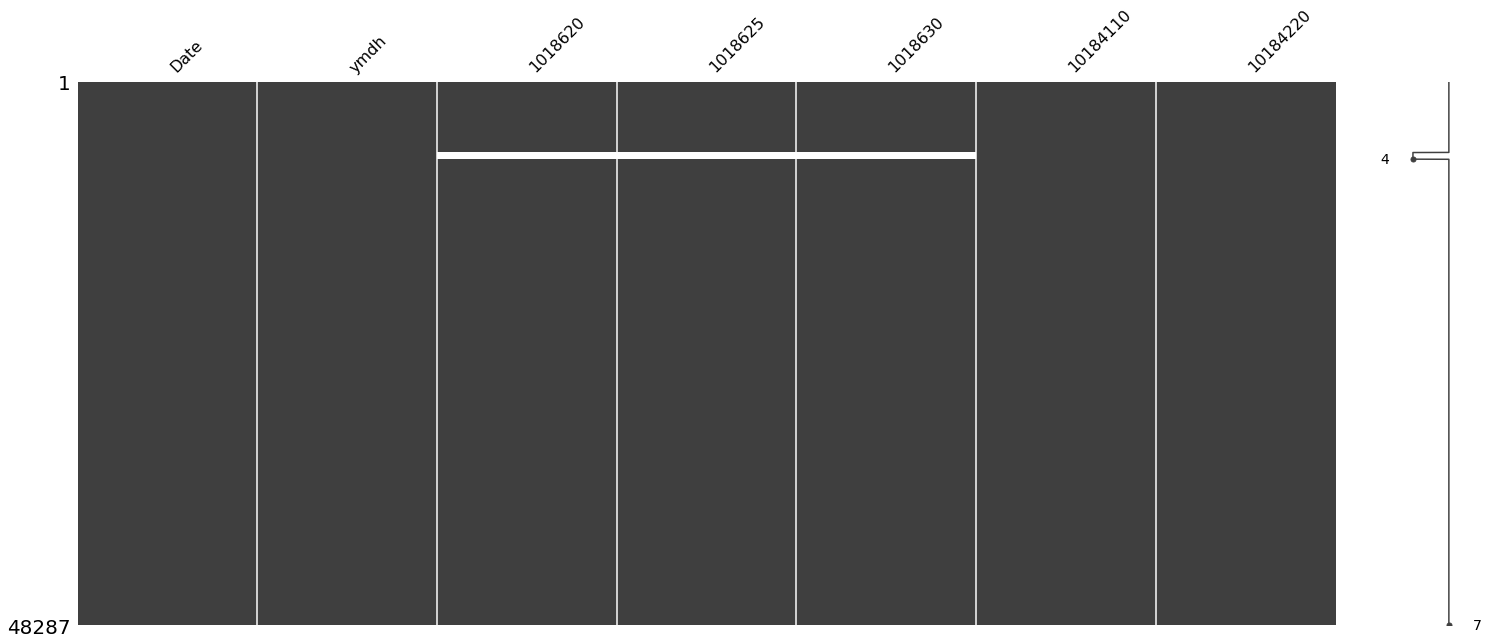

In [10]:
msno.matrix(df)

In [11]:
df.isnull().sum()

Date          0
ymdh          0
1018620     600
1018625     600
1018630     600
10184110      0
10184220      0
dtype: int64

,Date,ymdh,1018620,1018625,1018630,10184110,10184220
46103,2020-08-03 00:00:00,2020080300,1.16,1.645,1.135,0.0,0.0
46104,2020-08-03 01:00:00,2020080301,1.14,1.620,1.130,1.0,0.0
46105,2020-08-03 02:00:00,2020080302,1.15,1.610,1.090,0.0,5.0
46106,2020-08-03 03:00:00,2020080303,1.38,1.620,1.090,13.0,6.0
46107,2020-08-03 04:00:00,2020080304,1.41,1.780,1.200,8.0,1.0
46108,2020-08-03 05:00:00,2020080305,1.43,1.900,1.440,10.0,12.0
46109,2020-08-03 06:00:00,2020080306,1.71,2.100,1.700,15.0,7.0
46110,2020-08-03 07:00:00,2020080307,1.59,2.550,2.170,10.0,16.0
46111,2020-08-03 08:00:00,2020080308,1.49,2.350,2.000,2.0,8.0
46112,2020-08-03 09:00:00,2020080309,1.80,2.530,1.990,22.0,20.0


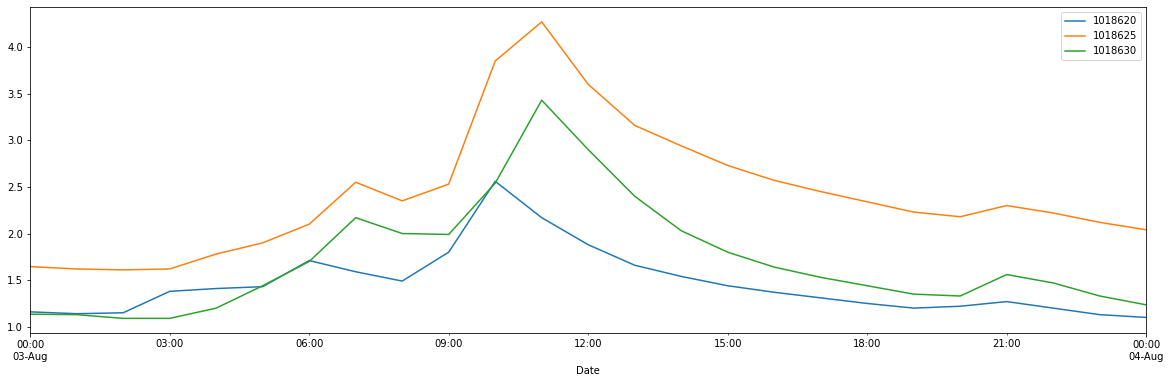

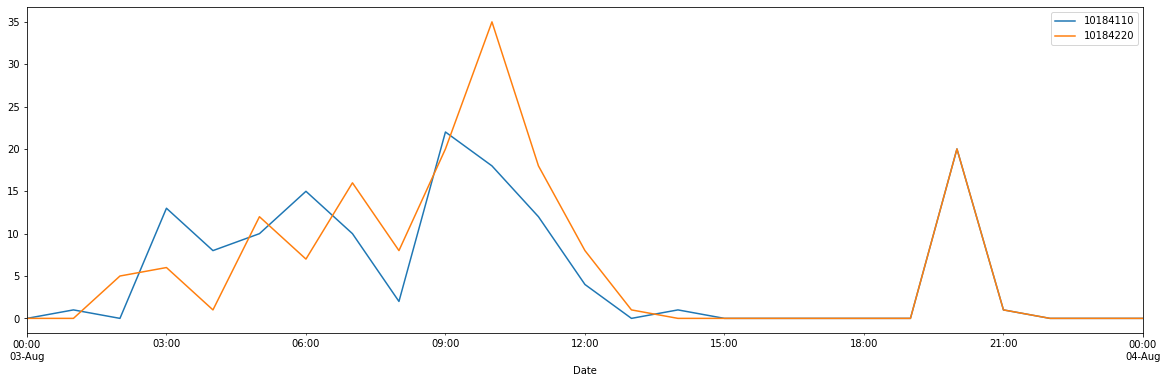

In [12]:
# 데이터 구조 체크 및 시각화

start = 2020080300
end = 2020080400

df_temp = df[(df['ymdh'] >= start) & (df['ymdh'] <= end)][['Date', '1018620', '1018625', '1018630']].set_index('Date')
df_temp.plot(figsize=(20,6))
df_temp = df[(df['ymdh'] >= start) & (df['ymdh'] <= end)][['Date', '10184110', '10184220']].set_index('Date')
df_temp.plot(figsize=(20,6))

display(df[(df['ymdh'] >= start) & (df['ymdh'] <= end)])

In [13]:
# 3차원 입력데이터를 만들기 위해 df_in이라는 데이터프레임으로 복사

df_in = df.drop(columns = ['Date', 'ymdh']).copy()
df_in

,1018620,1018625,1018630,10184110,10184220
0,0.20,1.08,-0.21,0.0,0.0
1,0.20,1.08,-0.21,0.0,0.0
2,0.20,1.08,-0.21,0.0,0.0
3,0.20,1.08,-0.22,0.0,0.0
4,0.20,1.08,-0.22,0.0,0.0
...,...,...,...,...,...
48282,0.15,1.07,-0.11,0.0,0.0
48283,0.15,1.07,-0.11,0.0,0.0
48284,0.15,1.07,-0.10,0.0,0.0
48285,0.15,1.08,-0.10,0.0,0.0


In [14]:
df_in[30000:].isnull().sum()

1018620     0
1018625     0
1018630     0
10184110    0
10184220    0
dtype: int64

In [57]:
# 값들을 0~1로 Min-Max 정규화 처리함

# define scaler
scaler = MinMaxScaler()
# fit scaler on the training dataset
scaler.fit(df_in.values)
# transform the training dataset
df_in_scaled = pd.DataFrame(scaler.transform(df_in.values), columns = df_in.columns)

# save the scaler
dump(scaler, open(path + 'scaler_1018630_8.pkl', 'wb'))

df_in_scaled


,1018620,1018625,1018630,10184110,10184220
0,0.063492,0.137838,0.026738,0.0,0.0
1,0.063492,0.137838,0.026738,0.0,0.0
2,0.063492,0.137838,0.026738,0.0,0.0
3,0.063492,0.137838,0.024064,0.0,0.0
4,0.063492,0.137838,0.024064,0.0,0.0
...,...,...,...,...,...
48282,0.043651,0.135135,0.053476,0.0,0.0
48283,0.043651,0.135135,0.053476,0.0,0.0
48284,0.043651,0.135135,0.056150,0.0,0.0
48285,0.043651,0.137838,0.056150,0.0,0.0


In [58]:
# 240시간(10일)에 대해 8개의 변수를 가지는 2차원 데이터셋을 기본 형태로 하는 3차원데이터셋(2차원을 기본으로 하는 배열)을 생성
# y_shift는 이후 1시간을 예측으로 함

x_range = 240
y_shift = 1
features = df_in_scaled.shape[1]
y_target_column = '1018630'

nb_samples = df_in_scaled.shape[0] - (x_range + y_shift - 1)

dataset_X_reshaped = np.zeros((nb_samples, x_range, features))
dataset_y_reshaped = np.zeros((nb_samples, y_shift))

j = 0
for i in range(nb_samples):
  if ((np.isnan(df_in_scaled[i:(i+x_range)].to_numpy()).sum()) > 0) | (np.isnan(df_in[y_target_column][i+x_range+y_shift-1]).sum() > 0) :
    continue 
  dataset_X_reshaped[j] = df_in_scaled[i:(i+x_range)].to_numpy()
  dataset_y_reshaped[j] = df_in[y_target_column][i+x_range+y_shift-1].reshape(-1)
  j = j + 1

dataset_X_reshaped = dataset_X_reshaped[0:j]
dataset_y_reshaped = dataset_y_reshaped[0:j]

print(dataset_X_reshaped.shape)
print(dataset_X_reshaped)

print(dataset_y_reshaped.shape)
print(dataset_y_reshaped)

(47207, 240, 5)
[[[0.06349206 0.13783784 0.02673797 0.         0.        ]
  [0.06349206 0.13783784 0.02673797 0.         0.        ]
  [0.06349206 0.13783784 0.02673797 0.         0.        ]
  ...
  [0.0515873  0.13243243 0.01871658 0.         0.        ]
  [0.0515873  0.13243243 0.01871658 0.         0.        ]
  [0.0515873  0.13243243 0.01871658 0.         0.        ]]

 [[0.06349206 0.13783784 0.02673797 0.         0.        ]
  [0.06349206 0.13783784 0.02673797 0.         0.        ]
  [0.06349206 0.13783784 0.02406417 0.         0.        ]
  ...
  [0.0515873  0.13243243 0.01871658 0.         0.        ]
  [0.0515873  0.13243243 0.01871658 0.         0.        ]
  [0.0515873  0.13243243 0.01871658 0.         0.        ]]

 [[0.06349206 0.13783784 0.02673797 0.         0.        ]
  [0.06349206 0.13783784 0.02406417 0.         0.        ]
  [0.06349206 0.13783784 0.02406417 0.         0.        ]
  ...
  [0.0515873  0.13243243 0.01871658 0.         0.        ]
  [0.0515873  0.13

In [59]:
#X_train, X_test, y_train, y_test = train_test_split(dataset_X_reshaped, dataset_y_reshaped, test_size=0.01)

# 50000번째 까지를 훈련데이터셋으로
# 그이후를 테스트데이터셋으로 구성함
X_train = dataset_X_reshaped[0:30000,:,:]
X_val = dataset_X_reshaped[30000:40000,:,:]
X_test = dataset_X_reshaped[40000:,:,:]

y_train = dataset_y_reshaped[0:30000]
y_val = dataset_y_reshaped[30000:40000]
y_test = dataset_y_reshaped[40000:]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(30000, 240, 5)
(7207, 240, 5)
(30000, 1)
(7207, 1)


In [67]:
# 기본 lstm모형을 생성
# lstm 은 stacked lstm형태로, stacked될 경우 return_sequence = TRUE 옵션 필요
# training=True옵션을 통해 dropout을 이용하여 매번 다른 결과값이 생성됨
# early stopping을 적용하여, 최적의 epoch를 결정함
# 현재 patience는 5로 설정되어 있음


def base_lstm(X_train, y_train, verbose = 1):
  inputs = Input(shape = (X_train.shape[1],X_train.shape[2]), name='inputs')
  x = LSTM(256, return_sequences=True, recurrent_dropout=drop_out_rate)(inputs) 
  x = LSTM(256, recurrent_dropout=drop_out_rate)(x) 
  output = Dense(units = 1, activation='linear', name='OUTPUT')(x)
  model = Model(inputs=inputs, outputs=output)
  opt = Adam()
  model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
  
  epc = 100
  es = EarlyStopping(monitor='val_loss', mode='min', patience=1, restore_best_weights=True)
  history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                      epochs=epc, verbose=verbose, callbacks=[es], 
                      batch_size=1024)
  return model
 
model_base = base_lstm(X_train, y_train)


Train on 30000 samples, validate on 10000 samples
Epoch 1/100
30000/30000 [==============================] - 55s 2ms/step - loss: 0.0110 - mae: 0.0584 - val_loss: 0.0041 - val_mae: 0.0541
Epoch 2/100
30000/30000 [==============================] - 53s 2ms/step - loss: 0.0023 - mae: 0.0238 - val_loss: 0.0015 - val_mae: 0.0293
Epoch 3/100
30000/30000 [==============================] - 53s 2ms/step - loss: 0.0012 - mae: 0.0145 - val_loss: 5.1071e-04 - val_mae: 0.0122
Epoch 4/100
30000/30000 [==============================] - 54s 2ms/step - loss: 8.8449e-04 - mae: 0.0124 - val_loss: 3.5475e-04 - val_mae: 0.0071
Epoch 5/100
30000/30000 [==============================] - 53s 2ms/step - loss: 7.5010e-04 - mae: 0.0108 - val_loss: 3.2945e-04 - val_mae: 0.0072
Epoch 6/100
30000/30000 [==============================] - 53s 2ms/step - loss: 7.1936e-04 - mae: 0.0117 - val_loss: 4.3865e-04 - val_mae: 0.0124


In [68]:
# 테스트 데이터셋에서 수위가 가장높았던 상위 10개 시점의 인덱스를 구함

idx = (-y_test).argsort(axis=None)[:10]
idx

array([5034, 5035, 5033, 5036, 5030, 5102, 5103, 5223, 5037, 5104])

In [69]:
# 위에서 뽑은 인덱스로 데이터셋을 구성
X_test_high_top10 = X_test[np.array(idx)]
y_test_high_top10 = y_test[np.array(idx)]

In [70]:
# 하나의 데이터셋에 대해 30개의 예측치를 도출하고,
# 이것의 평균과 분산을 구함
preds = model_base.predict(X_test_high_top10)

display(pd.DataFrame({'Obs' : y_test_high_top10.flatten(), 'Pred' : preds.flatten()}))

from sklearn.metrics import mean_squared_error 
MSE = mean_squared_error(preds.flatten(), y_test_high_top10.flatten()) 
np.sqrt(MSE)

,Obs,Pred
0,3.43,2.614544
1,2.90,2.896676
2,2.54,2.139396
3,2.40,2.810308
4,2.17,1.592307
5,2.09,1.784417
6,2.07,2.001872
7,2.03,1.888203
8,2.03,2.463780
9,2.02,2.040174


0.4042580174071943

In [71]:
strix = 45982
num = 200

preds = model_base.predict(X_test[4900:5100])

df_pred = pd.DataFrame({'Date' : df['Date'][strix:strix+num].values, 'Obs' : y_test[4900:5100].flatten(), 'Pred' : preds.flatten()})
df_pred

,Date,Obs,Pred
0,2020-07-28 23:00:00,0.130,0.093796
1,2020-07-29 00:00:00,0.130,0.095768
2,2020-07-29 01:00:00,0.130,0.097365
3,2020-07-29 02:00:00,0.130,0.098698
4,2020-07-29 03:00:00,0.130,0.099857
...,...,...,...
195,2020-08-06 02:00:00,0.765,0.735654
196,2020-08-06 03:00:00,0.750,0.717299
197,2020-08-06 04:00:00,0.800,0.753491
198,2020-08-06 05:00:00,0.950,0.862323


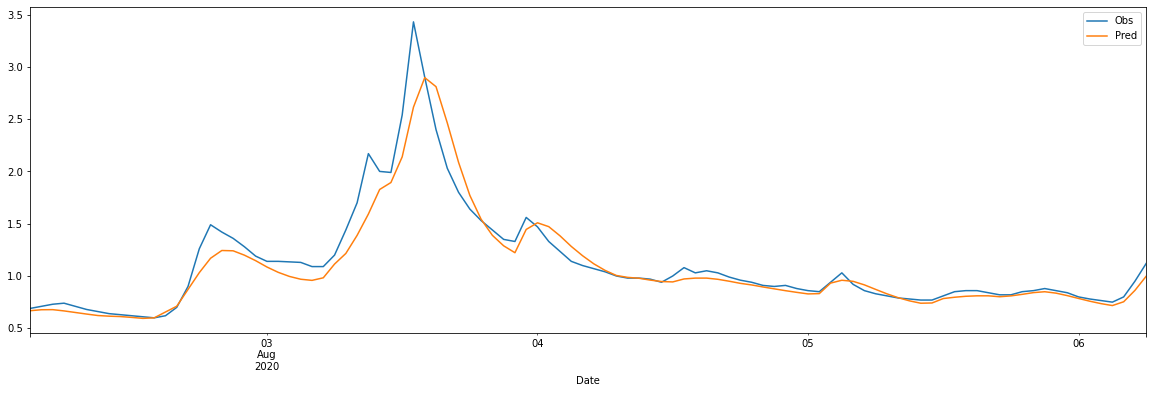

In [72]:
df_pred[['Date', 'Obs', 'Pred']][100:200].set_index('Date').plot(figsize=(20,6))